In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wednesday October 10 10:11:42 2023
Example Code for training an MRI Image Reconstruction Network from Inter4k Dataset

Methods details in : 
XXX

@author: Dr. Olivier Jaubert
"""

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

import numpy as np
import tensorflow as tf
try:  tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
except: print('running on CPU')
import random
import matplotlib.pyplot as plt
import datetime
import json

# # Local imports (works if you are in project folder)
import utils.create_tensorflow_dataset as dataset_utils
import utils.model_utils as model_utils
import utils.display_function as display_func

#Set seed for all packages
seed_value=1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
;

2023-11-02 12:03:17.750095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 12:03:17.844300: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 12:03:18.177367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/oj20/miniconda3/envs/tf022/lib/:/lib:/home/oj20/miniconda3/lib/:/lib:/home/oj20/miniconda3/lib/:/lib:
2023-11-02 12:03:18.177406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

''

In [2]:
data_folder = '/home/oj20/UCLjob/Project_Video/Datasets/Inter4K/60fps/UHD/'
cache_dir = '/home/oj20/UCLjob/Project_Video/Datasets/'

result_folder='TrainingFolder'
model_type='VarNet'
exp_name='Default_'+model_type
DEBUG=True
#Total number of samples from dataset used 
n= 12 if DEBUG else 692
epochs= 3 if DEBUG else 100

filenames_datasets=dataset_utils.split_training_test_set(data_folder,n=n,split=[0.75,0.10,0.15],verbose=1)
if model_type=='VarNet':
    dataset_withtransforms=dataset_utils.generate_dataset_VarNet(filenames_datasets,cache_dir,reset=1,DEBUG=DEBUG)
else:
    #TODO other cases
    dataset_withtransforms=dataset_utils.generate_dataset_VarNet(filenames_datasets,cache_dir,reset=1,DEBUG=DEBUG)
inputs_temp=next(iter(dataset_withtransforms[0].take(1)))
print(inputs_temp[0].shape)

100%|██████████| 1000/1000 [00:00<00:00, 5140078.43it/s]


Total/Train/Val/Test: 12 / 9 / 1 / 2 leftovers: 0
Config natural image to kspace: {'base_resolution': 240, 'phases': 24, 'masking': True, 'regsnr': [12, 22], 'sigma_coil': [2, 6], 'complex_transform': 4, 'num_coils': [30], 'add_phase': 2} 
Config preprocessing: {'base_resolution': 240, 'phases': 24, 'roll': 0, 'normalize_input': False, 'input_format': 'coil_compressed'} 
Config traj: {'acc': 14, 'phases': 15, 'center_lines': 8, 'half_fourier': 0.6, 'mask_type': 'noreselect'}
0
1
2


2023-11-02 12:04:06.821494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-02 12:04:07.281209: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 12:04:07.281526: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 12:04:07.281540: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-02 12:04:07.281949: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 12:04:07.281982: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-02 12:04:07.633763: I tensorflow/core/kernels/data/shuf

(1, 24, 240, 240, 2)


In [3]:
model=model_utils.load_models(inputs_temp,'VarNet',DEBUG=DEBUG)
learning_params=model_utils.load_learning_params('VarNet',DEBUG=DEBUG)
model.compile(optimizer=learning_params['optimizer'],
                    loss=learning_params['loss'],
                    metrics=learning_params['metrics'] or None,
                    run_eagerly=False)
model.summary()

Model: "var_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vn_recon_cell_u_net (VNReco  multiple                 43299     
 nCellUNet)                                                      
                                                                 
 vn_recon_cell_u_net_1 (VNRe  multiple                 43299     
 conCellUNet)                                                    
                                                                 
 vn_recon_cell_u_net_2 (VNRe  multiple                 43299     
 conCellUNet)                                                    
                                                                 
Total params: 129,897
Trainable params: 129,897
Non-trainable params: 0
_________________________________________________________________


In [4]:
#Defining Paths
exp_name += '_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = os.path.join(result_folder, exp_name)

callbacks=[]
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,
        save_best_only=True))
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(exp_dir,'logs')))

In [5]:
#Train Model
history=model.fit(dataset_withtransforms[0],
          epochs=learning_params['epochs'],
          verbose=1,
          callbacks=callbacks,
          validation_data=dataset_withtransforms[1])

Epoch 1/3


2023-11-02 12:04:46.422022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 4
2023-11-02 12:04:58.591497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-11-02 12:05:05.076910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5/9 [===============>..............] - ETA: 23s - loss: 0.8178

2023-11-02 12:05:36.536470: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-02 12:05:36.631217: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


9/9 [==============================] - ETA: 0s - loss: 0.7353

2023-11-02 12:05:39.202189: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-02 12:05:49.279104: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-02 12:05:49.382810: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. I

INFO:tensorflow:Assets written to: TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model/assets


9/9 [==============================] - 87s 6s/step - loss: 0.7353 - val_loss: 0.3907
Epoch 2/3
9/9 [==============================] - ETA: 0s - loss: 0.5444

INFO:tensorflow:Assets written to: TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model/assets


9/9 [==============================] - 12s 1s/step - loss: 0.5444 - val_loss: 0.2898
Epoch 3/3
9/9 [==============================] - ETA: 0s - loss: 0.4878

INFO:tensorflow:Assets written to: TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model/assets


9/9 [==============================] - 13s 2s/step - loss: 0.4878 - val_loss: 0.2506


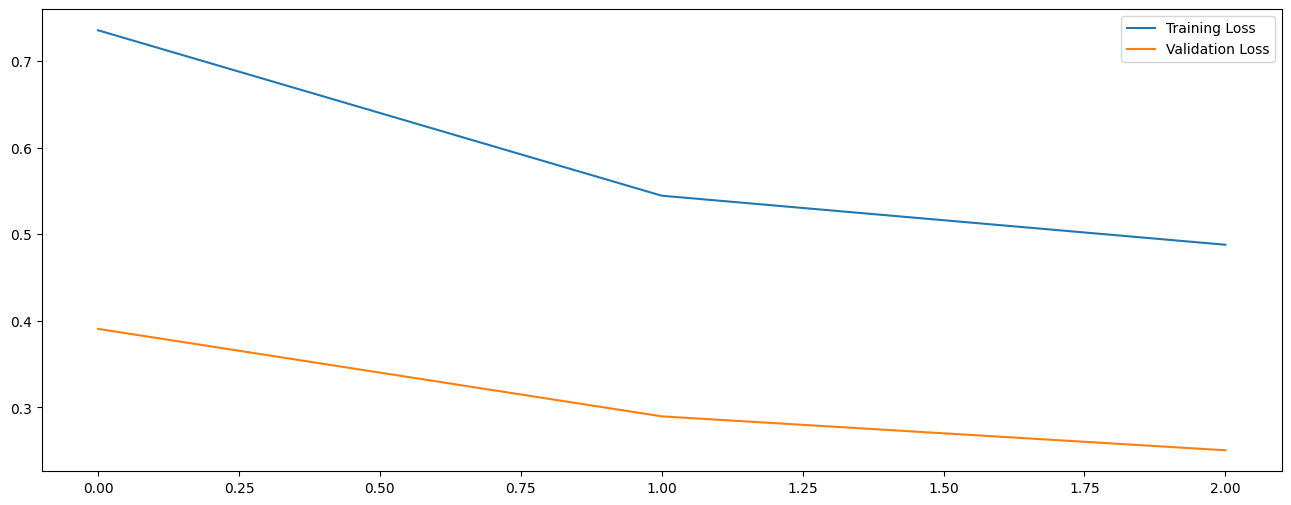

In [6]:
fig = plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
leg = plt.legend()

In [7]:
#Evaluate On Test Set
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
model.load_weights(checkpoint_filepath)
result = model.evaluate(dataset_withtransforms[2])
#results_dict=dict(zip(model.metrics_names, result))
results_dict={model.metrics_names[0]: result} #when only 1 metric
filename = os.path.join(exp_dir,'results.json')
with open(filename, 'w') as f:
    f.write(json.dumps(results_dict))

2023-11-02 12:06:23.351882: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model: FAILED_PRECONDITION: TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-11-02 12:06:35.060646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 4


1/2 [==============>...............] - ETA: 18s - loss: 0.3670

2023-11-02 12:06:41.253277: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-02 12:06:41.253774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2/2 [==============================] - 18s 116ms/step - loss: 0.4123


2023-11-02 12:06:41.598347: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model: FAILED_PRECONDITION: TrainingFolder/Default_VarNet_20231102_120429/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


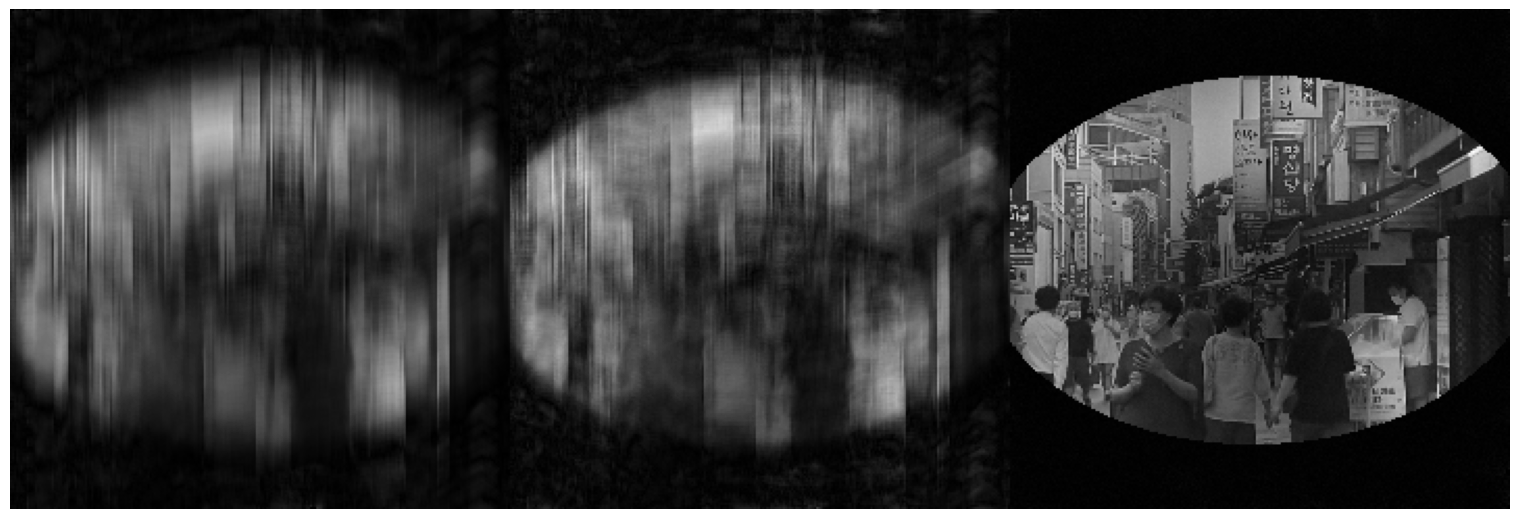

In [8]:
#Inference
#Preproc series 1
model.load_weights(checkpoint_filepath)
inputs=next(iter(dataset_withtransforms[-1]))
output = model(inputs)
element=0
zfill=tf.complex(inputs[element][0,...,0],inputs[element][0,...,1])
element=-1
gt=tf.complex(inputs[element][0,...,0],inputs[element][0,...,1])
output=tf.complex(output[0,...,0],output[0,...,1])

#From Left to Right: Input, Ground Truth, Reconstructed.
plot_image=np.abs(np.concatenate((zfill,output,gt),axis=2))
savepath=os.path.join(exp_dir,'video_'+model_type)
display_func.plotVid(plot_image,axis=0,vmin=0,vmax=1,interval=41.66,savepath=savepath)